# Property Querying

The motivation behind this tutorial is to demonstrate my method for querying the properties of removed and non-removed triples and compare the the resulting differences between the sets. I used the Neo4j python API to query the knowledge graph and ultimately store the data in .xlsx files.   

This tutorial demonstrates how to query CPE-CVE triples for the 5 different properties in CPE nodes and the 1 property in CVE nodes. The exact same process can be applied for CVE-CWE triples and their node properties.

We first need to set-up our knowledge graph in Neo4j. 

## Set-up

If you have a system with a GUI that can download applications from a browser, you can use the Neo4J desktop application. In that case, reference Zhenpeng Shi's tutorial at: https://github.com/nislab/threat-knowledge-graph/blob/main/neo4j_import/threat_kg_with_neo4j.md. <br>

If you're using a terminal-based Debian system such as a NERC Openstack virtual machine, follow the tutorial at: https://github.com/sevvalboylu/BU-RH-Threat-Knowledge/blob/main/Tutorials/Visualize_with_Neo4j/Neo4J_NERC_Setup.md 

In either case, we will need the Neo4j python API. Make sure Neo4j support is installed with `pip install neo4j`. <br>

The scripts here also use the `panda`,`pickle`, `xlsxwriter`, and `tqdm` packages in addition to the `neo4j` package.

We first need to start the local server that hosts Neo4j application by simply clicking the start in project tab in the Neo4j desktop application (shown below) or by using `sudo /usr/bin/neo4j-admin server start` for the terminal-based system.

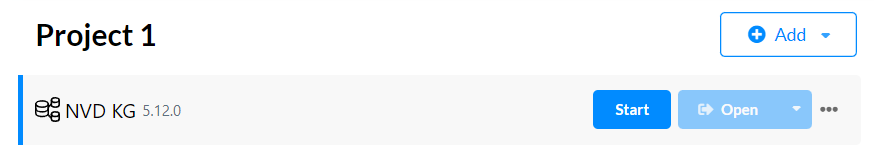

<br> The rest of the tutorial covers Python code that can be run in your environment. I personally had a new `.py` file for each section here, so there are some redudent `import <package_name>` lines in the code. This tutorial was based on Python 3.7.

## Removed Triples Querying

We first need to connect to the server in our python script. The default host should just always be `bolt://localhost:7687`. The password field is set when the project is created and the default user field is `neo4j`

In [ ]:
from neo4j import GraphDatabase

URI = "bolt://localhost:7687"
AUTH = ("user", "password")

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

We then set up our dict data structures that will store the number of occurrences for each property. There are 5 types of properties for CPE nodes, meaning we need a 2D dictionary for the CPE nodes. Each property type will have a dict with pairs of  specific property names and their occurrence counts. There is only 1 property for CVE nodes (its name), so we can just do a normal 1D dictionary, with pairs of peoperty names and their occurrence counts. We will also have a list to store triples that the query doesn't work for.

In [ ]:
cpe_properties_dict = {
  "Part": {},
  "Target_sw": {},
  "Target_hw": {},
  "Product": {},
  "Vendor": {},
  "Name": {}
}

cve_nodes = {}

invalid_triples = []

We then load in our set of triples that we want to query the properties for via the `pandas` library. We will query the removed triples first, based on our analysis from the August 2021 NVD data and the November 2022 NVD data. 

We had done some preprocessing in previous scripts to get triples in an usable format. The tutorial can be found at: https://github.com/nislab/threat-knowledge-graph/tree/main/preprocess and the saved files can be found at: https://github.com/nislab/threat-knowledge-graph/tree/main/threat_kg/saved

We did further preprocessing to seperate out removed and non-removed triples in this tutorial: https://github.com/sevvalboylu/BU-RH-Threat-Knowledge/blob/main/NVD-Removals/Scoring_Removed_and_Non-Removed_Triples_Tutorial.ipynb

In [ ]:
import pandas as pd    
removed_cpe2cve = []
removed_cpe2cve_df = pd.read_csv(".../removed_cpe2cve.csv", usecols=["subject", "predicate", "object"])
for i,r in removed_cpe2cve_df.iterrows():
    removed_cpe2cve.append([r['subject'],r['predicate'],r['object']])

We then use the `tqdm` package to set-up a progress bar. This part is totally optional, but does provide a useful reference for runtime. There may be some display bugs as the `tqdm` package and `print()` function can interfere with each other somewhat, but they won't affect much.

In [ ]:
from tqdm import tqdm
progress = tqdm (range(len(removed_cpe2cve)), desc="Progress" ,position=0, leave=True, ascii=False, ncols=75)

We then parse through our set. For each triple, we first update the progress bar. <br>

Then, we query the Neo4j for the properties of the CPE node. If the query doesn't return anything, we append the triple to our `invalid_triples` list and move on to the next triple. Otherwise, if the specific property is already a key in our `cpe_properties_dict` dict, we just increment that key's corresponding value by 1. If it doesn't exist, we create a new pair with the property as the key and a value of 1. 

We then also do the same with the cve names in our triple to the `cve_nodes` dict.

In [ ]:
for triple in removed_cpe2cve:
    
    progress.update(1)
    
    #direct properties
    query_string = "match (p:CPE)-[:MatchingCVE]->(v:CVE)\
where p.Name = \"" + triple[0] + "\" AND v.Name = \"" + triple[2] +"\"\
return p, v"

    records, summary, keys = driver.execute_query(
        query_string,
        database_="neo4j",
    )
    
    if(records == []):
        invalid_triples.append(triple)
        continue
        
    current_props = records[0][0]._properties
    for property_name in current_props:
        property_value = current_props[property_name]
        if property_value in cpe_properties_dict[property_name]:
            cpe_properties_dict[property_name][property_value] += 1;
        else:
            cpe_properties_dict[property_name][property_value] = 1;
    
     
    if triple[2] in cve_nodes:
        cve_nodes[triple[2]] += 1; 
    else:
        cve_nodes[triple[2]] = 1;

Theorectically, there shouldn't be any invalid triples, but I believe because of inconsistencies or errors in naming and triple extraction, I did encounter some invalid triples, but not a significant amount.

Once we've extracted the property counts for the removed triples, we can store them via the `pickle` package for backup and usage in later scripts. Do note that `pickle` automatically stores the data structures in the same directory as your script.

In [ ]:
import pickle 
with open('removed_cpe_properties_counts.pkl', 'wb') as f:
    pickle.dump(cpe_properties_dict, f)

with open('removed_cve_names_counts.pkl', 'wb') as f:
    pickle.dump(cve_nodes, f)

with open('removed_cpe_properties_counts.pkl', 'wb') as f:
    pickle.dump(cpe_properties_dict, f)

## Non-removed Query

The exact same process can be applied to the non-removed set. 

In [ ]:
import pandas as pd
from tqdm import tqdm
from neo4j import GraphDatabase

#connecting to neo4j
URI = "bolt://localhost:7687"
AUTH = ("user", "password")

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

#loading in triples
nonremoved_cpe2cve = []
nonremoved_cpe2cve_df = pd.read_csv(".../nonremoved_cpe2cve.csv", usecols=["subject", "predicate", "object"])
for i,r in nonremoved_cpe2cve_df.iterrows():
    nonremoved_cpe2cve.append([r['subject'],r['predicate'],r['object']])

#setting up data structs
cpe_properties_dict = {
  "Part": {},
  "Target_sw": {},
  "Target_hw": {},
  "Product": {},
  "Vendor": {},
  "Name": {}
}

cve_nodes = {}
invalid_triples = []

#progress bar
from tqdm import tqdm
progress = tqdm (range(len(nonremoved_cpe2cve)), desc="Progress" ,position=0, leave=True, ascii=False, ncols=75)


#query
for triple in nonremoved_cpe2cve:
    
    progress.update(1)
    
    #cpe properties
    query_string = "match (p:CPE)-[:MatchingCVE]->(v:CVE)\
where p.Name = \"" + triple[0] + "\" AND v.Name = \"" + triple[2] +"\"\
return p, v"

    records, summary, keys = driver.execute_query(
        query_string,
        database_="neo4j",
    )
    
    if(records == []):
        invalid_triples.append(triple)
        continue
        
    current_props = records[0][0]._properties
    for property_name in current_props:
        property_value = current_props[property_name]
        if property_value in cpe_properties_dict[property_name]:
            cpe_properties_dict[property_name][property_value] += 1;
        else:
            cpe_properties_dict[property_name][property_value] = 1;
    
    #cve nodes
    if triple[2] in cve_nodes:
        cve_nodes[triple[2]] += 1;
    else:
        cve_nodes[triple[2]] = 1;
    
#saving
import pickle 
with open('nonremoved_cpe_properties_counts_dict.pkl', 'wb') as f:
    pickle.dump(cpe_properties_dict, f)

with open('nonremoved_cve_names_counts.pkl', 'wb') as f:
    pickle.dump(cve_nodes, f)

## Converting to Percentage

Since the scale of the two sets are drastically different, comparing the actual number of occurrences won't be productive as the non-removed set will vastly outnumber the removed set no matter what. Instead, we will divide the number of the occurrences by the length of the set to get a percentage of occurrences, and compare the two sets that way.

Starting with the removed set, we can load our dicts via the `pickle` library if we're working in a new script. This isn't necessary if we were to still work in the same file that created the dict. 

In [ ]:
import pickle
with open('removed_cpe_properties_counts.pkl', 'rb') as f:
    removed_cpe_properties_dict = pickle.load(f)

with open('removed_cve_names_counts.pkl', 'rb') as f:
    removed_cve_names = pickle.load(f)

In order to get the length to divide by, we need to load in our removed set if we hadn't already.

In [ ]:
import pandas as pd
removed_cpe2cve = []
removed_cpe2cve_df = pd.read_csv(".../removed_cpe2cve.csv", usecols=["subject", "predicate", "object"])
for i,r in removed_cpe2cve_df.iterrows():
    removed_cpe2cve.append([r['subject'],r['predicate'],r['object']])

We create a new dict with the same keys, but divide each old value by the length of our set, and optionally multiply that value to convert it to a 0-100 scale instead of a 0-1 scale. Then, we save our new dict with the `pickle` library.

In [ ]:
#cpe properties
removed_property_percentage = {}
for property_name in removed_cpe_properties_dict:
    removed_property_percentage.update({property_name: {}})
    for current_prop in removed_cpe_properties_dict[property_name]:
        value = removed_cpe_properties_dict[property_name][current_prop]
        removed_property_percentage[property_name].update({current_prop: value*100 / len(removed_cpe2cve)})
            
with open('removed_cpe_properties_percentages.pkl', 'wb') as f:
    pickle.dump(removed_property_percentage, f)

#cve names
removed_cve_names_percentage = {}
for node in removed_cve_names:
    value = removed_cve_names[node]
    removed_cve_names_percentage.update({node: value*100 / len(removed_cpe2cve)})
with open('removed_cve_names_percentage.pkl', 'wb') as f:
    pickle.dump(removed_cve_names_percentage, f)

The same process can be done for the non-removed set as well.

In [ ]:
#loading in data
with open('nonremoved_cpe_properties_counts.pkl', 'rb') as f:
    nonremoved_cpe_properties_dict = pickle.load(f)
    
with open('nonremoved_cve_names_counts.pkl', 'rb') as f:
    nonremoved_cve_names = pickle.load(f)
    
nonremoved_cpe2cve = []
nonremoved_cpe2cve_df = pd.read_csv(".../nonremoved_cpe2cve.csv", usecols=["subject", "predicate", "object"])
for i,r in nonremoved_cpe2cve_df.iterrows():
    nonremoved_cpe2cve.append([r['subject'],r['predicate'],r['object']])

#cpe properties
nonremoved_property_percentage_list = {}
for property_name in nonremoved_cpe_properties_dict:
    nonremoved_property_percentage_list.update({property_name: {}})
    for current_prop in nonremoved_cpe_properties_dict[property_name]:
        value = nonremoved_cpe_properties_dict[property_name][current_prop]
        nonremoved_property_percentage_list[property_name].update({current_prop: value*100 / len(nonremoved_cpe2cve)})

with open('nonremoved_cpe_properties_percentages.pkl', 'wb') as f:
    pickle.dump(nonremoved_property_percentage_list, f)

#cve names
nonremoved_cve_names_percentage = {}
for node in nonremoved_cve_names:
    value = nonremoved_cve_names[node]
    nonremoved_cve_names_percentage.update({node: value*100 / len(nonremoved_cpe2cve)})
with open('nonremoved_cve_names_percentage.pkl', 'wb') as f:
    pickle.dump(nonremoved_cve_names_percentage, f)

## Percentage Comparison

We can now find the difference in percentage occurrences in the two sets to observe where the largest differences occur. 

To start, we load in the percentage dicts.

In [ ]:
import pickle 
with open('nonremoved_cpe_properties_percentages.pkl', 'rb') as f:
    nonremoved_cpe_properties_percentages_dict = pickle.load(f)

with open('removed_cpe_properties_percentages.pkl', 'rb') as f:
    removed_cpe_properties_percentages_dict = pickle.load(f)


We first create a dict for the percentage difference, `cpe_property_difference_dict`, which be structured the same as the other dicts but contain the values of the percentage differences as each key's value. Then for each property in the removed set's dict, we get the percentage in the removed dict and set it to `removed_percentage`. <br>

We look for the percentage for that same key in the non-removed set's dict and set it to `nonremoved_percentage`. If we can't find it, that means that key never showed up in the non-removed set, so we set the `nonremoved_percentage` to 0. <br>

Lastly, we update `cpe_property_difference_dict` with our current property as our key and `removed_percentage - nonremoved_percentage` as its corresponding value

In [ ]:
cpe_property_difference_dict = {}
for property_name in removed_cpe_properties_percentages_dict:
    cpe_property_difference_dict.update({property_name: {}})
    for current_prop in removed_cpe_properties_percentages_dict[property_name]:
        removed_percentage = removed_cpe_properties_percentages_dict[property_name][current_prop]
        try:
            nonremoved_percentage = nonremoved_cpe_properties_percentages_dict[property_name][current_prop]
        except KeyError:
            nonremoved_percentage = 0
        cpe_property_difference_dict[property_name].update({current_prop: removed_percentage - nonremoved_percentage})
    


We have gotten the percentage difference for all the properties in the removed set's dict, but there may have been properties in the non-removed set's dict that never showed in the removed set's dict. So, we will need to repeat the process above by parsing through non-removed set's dict instead of the removed set's, skipping over any properties that were already covered.

In [ ]:
for property_name in nonremoved_cpe_properties_percentages_dict:
    for current_prop in nonremoved_cpe_properties_percentages_dict[property_name]:
        nonremoved_percentage = nonremoved_cpe_properties_percentages_dict[property_name][current_prop]
        if current_prop in cpe_property_difference_dict:
            continue;
        
        #should always fail the try since this is meant to only capture elements not in removed triples
        try:
            removed_percentage = removed_cpe_properties_percentages_dict[property_name][current_prop]
        except KeyError:
            removed_percentage = 0
        cpe_property_difference_dict[property_name].update({current_prop: removed_percentage - nonremoved_percentage})
    

Since dicts are techincally unsorted data structures, we will convert our CPE node's property dict of dicts into a dict of tuples, which can be sorted. We will then sort by descending order of the absolute value of the our values in `cpe_property_difference_dict` in order to see what properties cause the largest difference.

In [ ]:
cpe_property_difference_tuple_sorted = {};
for property_name in removed_cpe_properties_percentages_dict:
    temp_dict = {property_name: sorted(cpe_property_difference_dict[property_name].items(), key=lambda item: abs(item[1]), reverse = True)}
    cpe_property_difference_tuple_sorted.update(temp_dict)

We can then save our new data structure.

In [ ]:
with open('cpe_property_difference_tuple_sorted.pkl', 'wb') as f:
    pickle.dump(cpe_property_difference_tuple_sorted, f)

Doing this with the CVE-names is a similiar process, though parsing through our dicts is actually a bit more straightforward since it isn't multi-dimensional like our CPE-properties dict.

In [ ]:
import pickle 

with open('nonremoved_cve_names_percentages.pkl', 'rb') as f:
    nonremoved_cve_names_percentage_dict = pickle.load(f)

with open('removed_cve_names_percentages.pkl', 'rb') as f:
    removed_cve_names_percentage_dict = pickle.load(f)

cve_names_difference_dict = {}
for property_name in removed_cve_names_percentage_dict:
    cve_names_difference_dict.update({property_name: {}})
    removed_percentage = removed_cve_names_percentage_dict[property_name]
    try:
        nonremoved_percentage = nonremoved_cve_names_percentage_dict[property_name]
    except KeyError:
        nonremoved_percentage = 0
    cve_names_difference_dict.update({property_name: removed_percentage - nonremoved_percentage})

for property_name in nonremoved_cve_names_percentage_dict:
    nonremoved_percentage = nonremoved_cve_names_percentage_dict[property_name]
    
    if property_name in cve_names_difference_dict:
        continue;
    
    #should always fail the try since this is meant to only capture elements not in removed triples
    try:
        removed_percentage = removed_cve_names_percentage_dict[property_name]
    except KeyError:
        removed_percentage = 0
        
    cve_names_difference_dict.update({property_name: removed_percentage - nonremoved_percentage})


cve_names_difference_tuple_sorted = sorted(cve_names_difference_dict.items(), key=lambda item: abs(item[1]), reverse = True);

with open('cve_names_difference_tuple_sorted.pkl', 'wb') as f:
    pickle.dump(cve_names_difference_tuple_sorted, f)

## Writing to `.xlsx` Files

We now have all the data we're looking for in the forms of python data structures. We can convert those into more readable and portable excel files via the `xlsxwriter` package.

First, starting with our CPE-properties, we need to import in our relevant data structures if we're working in a seperate file than before.

In [ ]:
import pickle 

with open('cpe_property_difference_tuple_sorted.pkl', 'rb') as f:
    cpe_property_difference_tuple_sorted = pickle.load(f)

with open('nonremoved_cpe_properties_percentages.pkl', 'rb') as f:
    nonremoved_cpe_properties_percentages_dict = pickle.load(f)

with open('removed_cpe_properties_percentages.pkl', 'rb') as f:
    removed_cpe_properties_percentages_dict = pickle.load(f)

with open('nonremoved_cpe_properties_counts.pkl', 'rb') as f:
    nonremoved_cpe_properties_dict = pickle.load(f)

with open('removed_cpe_properties_counts.pkl', 'rb') as f:
    removed_cpe_properties_dict = pickle.load(f)

We then create our excel file and add bold formatting for our headers if desired.

In [ ]:
import xlsxwriter
workbook = xlsxwriter.Workbook('cpe_properties_difference.xlsx')

# Add a bold format
bold = workbook.add_format({'bold': True})

For each property type of a CPE node, we create a new sheet in our excel file. <br>

Within that sheet, we will have a column for the specific property value/name, the percentage difference, the removed percentage, the non-removed percentage, the removed number of occurrences, and the non-removed number of occurrences. 

We then write into the worksheet the corrresponding value for each column for each property value/name.

In [ ]:
for property_name in cpe_property_difference_tuple_sorted:
    worksheet = workbook.add_worksheet(property_name)
    
    worksheet.write(0, 0, property_name, bold)
    worksheet.write(0, 1, "Percentage Difference (Removed - Non-removed)", bold)
    worksheet.write(0, 2, "Removed Percentage", bold)
    worksheet.write(0, 3, "Non-removed Percentage", bold)
    worksheet.write(0, 4, "Removed Occurrences", bold)
    worksheet.write(0, 5, "Non-removed Occurrences", bold)
    
    row = 1
    for element in cpe_property_difference_tuple_sorted[property_name]:
        worksheet.write(row, 0, element[0])
        worksheet.write(row, 1, element[1])
        
        try:
            current_removed_percentage = removed_cpe_properties_percentages_dict[property_name][element[0]]
        except:
            current_removed_percentage = 0
        worksheet.write(row, 2, current_removed_percentage)
        
        try:
            current_nonremoved_percentage = nonremoved_cpe_properties_percentages_dict[property_name][element[0]]
        except:
            current_nonremoved_percentage = 0
        worksheet.write(row, 3, current_nonremoved_percentage)
        
        try:
            removed_occurrences = removed_cpe_properties_dict[property_name][element[0]]
        except:
            removed_occurrences = 0
        worksheet.write(row, 4, removed_occurrences)
        
        try:
            nonremoved_occurrences = nonremoved_cpe_properties_dict[property_name][element[0]]
        except:
            nonremoved_occurrences = 0
        worksheet.write(row, 5, nonremoved_occurrences)
        
        row += 1

Finally, we close our file.

In [ ]:
workbook.close()

We can do the same for the CVE names

In [ ]:
import pickle
with open('cve_names_difference_tuple_sorted.pkl', 'rb') as f:
    cve_names_difference_tuple_sorted = pickle.load(f)

with open('nonremoved_cve_names_percentages.pkl', 'rb') as f:
    nonremoved_cve_names_percentage_dict = pickle.load(f)

with open('removed_cve_names_percentages.pkl', 'rb') as f:
    removed_cve_names_percentage_dict = pickle.load(f)

with open('nonremoved_cve_names_counts.pkl', 'rb') as f:
    nonremoved_cve_names_dict = pickle.load(f)
    
with open('removed_cve_names_counts.pkl', 'rb') as f:
    removed_cve_names_dict = pickle.load(f)

import xlsxwriter
workbook = xlsxwriter.Workbook('cve_names_difference.xlsx')
# Add a bold format
bold = workbook.add_format({'bold': True})

worksheet = workbook.add_worksheet("CVE Node")

worksheet.write(0, 0, "CVE Name", bold)
worksheet.write(0, 1, "Percentage Difference (Removed - Non-removed)", bold)
worksheet.write(0, 2, "Removed percentage", bold)
worksheet.write(0, 3, "Non-removed percentage", bold)
worksheet.write(0, 4, "Removed Occurrences", bold)
worksheet.write(0, 5, "Non-removed Occurrences", bold)

row = 1
for element in cve_names_difference_tuple_sorted:
    worksheet.write(row, 0, element[0])
    worksheet.write(row, 1, element[1])
    
    try:
        current_removed_percentage = nonremoved_cve_names_percentage_dict[element[0]]
    except:
        current_removed_percentage = 0
    worksheet.write(row, 2, current_removed_percentage)
    
    try:
        current_nonremoved_percentage = removed_cve_names_percentage_dict[element[0]]
    except:
        current_nonremoved_percentage = 0
    worksheet.write(row, 3, current_nonremoved_percentage)
    

    try:
        removed_occurrences = removed_cve_names_dict[element[0]]
    except:
        removed_occurrences = 0
        
    worksheet.write(row, 4, removed_occurrences)
    
    try:
        nonremoved_occurrences = nonremoved_cve_names_dict[element[0]]
    except:
        nonremoved_occurrences = 0
    worksheet.write(row, 5, nonremoved_occurrences)
    
    
    row += 1
    
workbook.close()

## Conclusion

The same process and code can be easily applied to CVE-CWE triples as well. 

We have our results from this process and discussion on them in a seperate document.